<a href="https://colab.research.google.com/github/vamsikrishna00466/time_series/blob/main/Spare_parts_demand_forecasting_with_VAR_Project_V_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was spare parts demand forcasting SKU level with Vector Auto Regression version 1.0

*    Adf test(for stationary)
*    grangercausalitytest(for x-lag relation ship)

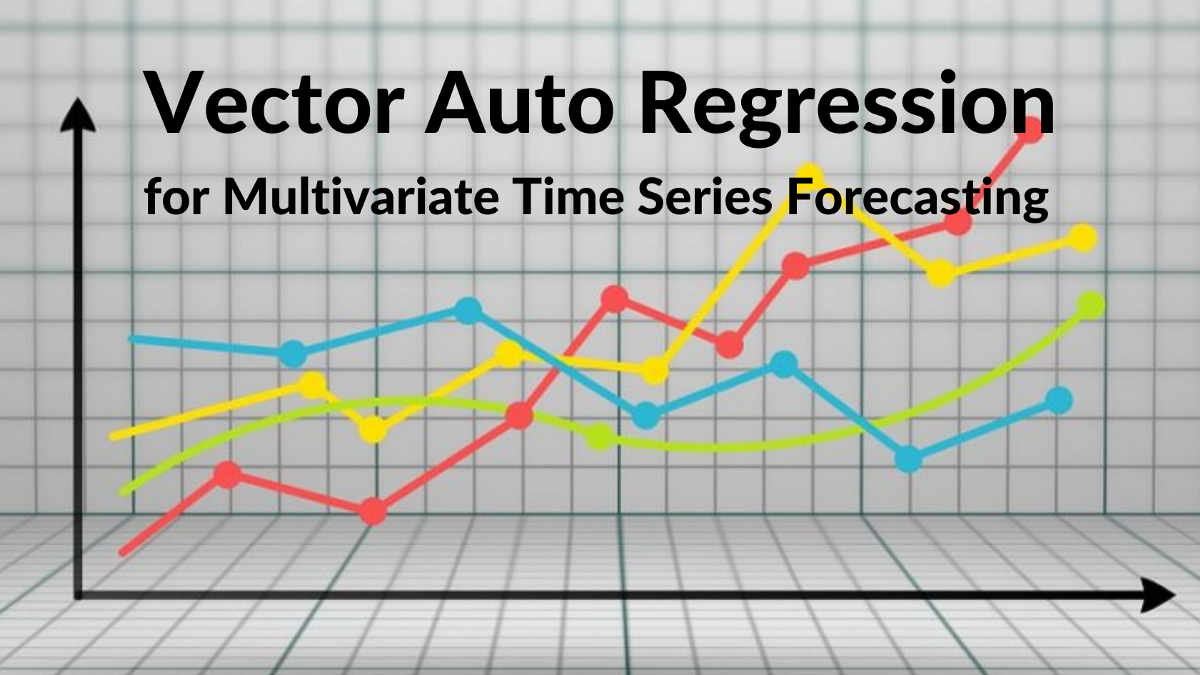

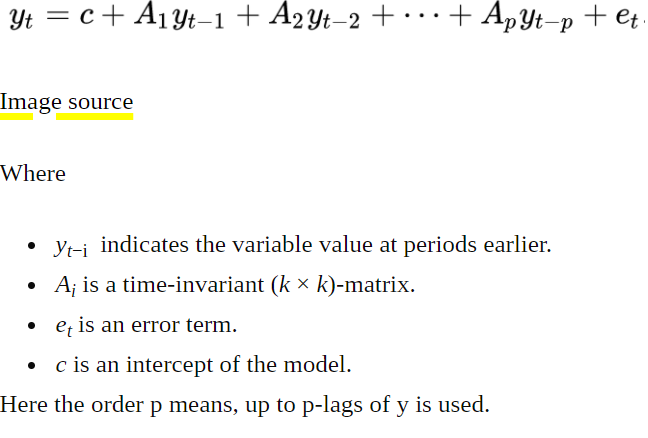

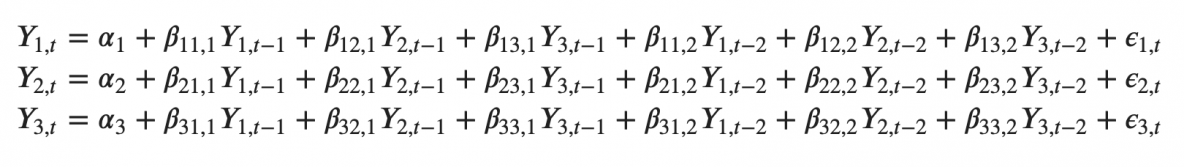

In [1]:
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  import datetime
  pd.set_option('display.max_columns', 20)
  import warnings
  warnings.filterwarnings('ignore')

In [2]:
path='/content/drive/MyDrive/SCA Projects/Forecasting /DFP11.01.2022.xlsx'

In [3]:
class spare_parts_analysis:
  #importing Necessary Librarie
  def __init__(self, path):
    self.path = path

  def raw_data_cleaning(self,path):
    #importing data
    print('collecting data....')
    df= pd.read_excel(path)
    print('Data collection completed')
    #droping unecessary cloumns by client guidence
    print('\nData clening in processing...')
    droping_columns = df.loc[:, datetime.datetime(2017, 12, 1, 0, 0): 'Total'].columns.to_list()
    df1 = df.copy()
    del df1['Total.1']
    for i in droping_columns:
      del df1[i]
    #converting date columns into rows
    df2 = df1.melt(id_vars=["Part No. D", "NDP",'Category','MOQ','Opening Stock'],
                   var_name="Month",value_name="demand")
    #HAndling missing values
    df2['demand'] = df2['demand'].fillna(0)
    df2['Opening Stock'] = df2['Opening Stock'].fillna(0)
    df2['Part No. D'] = df2['Part No. D'].fillna('Missing_sku')
    df2 = df2[df2['Part No. D']!='Missing_sku'].reset_index(drop=bool)
    df2['Month'] = pd.to_datetime(df2['Month'])
    #dulpicates removing
    df2 = df2.groupby(by=['Month','Part No. D']).agg({'demand':'first',
                                                      'Category':'first',
                                                      'Opening Stock':'first',
                                                      'MOQ':'first',
                                                      'NDP':'first',
                                                      }).reset_index()
    print('Data clened')
    return df2
  
  def data_manuplulation_from_raw_data(self,path,m):
    df1 = self.raw_data_cleaning(path)
    p = round(m/df1['Month'].nunique(),2)*100
    #Sku And Category adding
    print(f'\nmore than {m} months no sales skus removing...')
    df1['sku'] = df1['Part No. D']+'_'+df1['Category']
    ##converting categories into columns
    df2 = df1.pivot(index=['Month'], columns='sku', values='demand')
    for i in df2.columns:
      Zeros = round((len(df2[df2[i]==0])/len(df2))*100,3)
      if Zeros>p:
        del df2[i]
    print(f'more than {m} months no sales skus removed\n')
    return df2

In [ ]:
sku_analysis = spare_parts_analysis(path)

df = sku_analysis.data_manuplulation_from_raw_data(path,m=12)

In [ ]:
print('Number of months and skus:',df.shape)

In [6]:
def adf_test_all_skus(df,alpha=0.05):
  from statsmodels.tsa.stattools import adfuller
  ## Hyphothesis Testing for distribution checking(normally distributed or not)
  adf_stationary = pd.DataFrame()
  for i in df.columns.to_list():
    r = adfuller(df[i], autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]} 
    p = output['pvalue']
    adf_stationary = adf_stationary.append({'SKU':i,
                                            'P_value':p
                                            }
                                           ,ignore_index=True)
  print('Number of SKU are Stationary:',len(adf_stationary[adf_stationary['P_value']<alpha]))
  print('Number of SKU are Non-Stationary:',len(adf_stationary[adf_stationary['P_value']>=alpha]))
  return adf_stationary

In [ ]:
adf_0 = adf_test_all_skus(df,alpha=0.05)

In [8]:
r1 = df[['A0002_Regular','A0003_Regular','A0004_Regular','A0006_Regular',
              'A0007_Regular','A0008_Regular','A0009_Regular','A0010_Regular',
              ]]

In [ ]:
adf_0 = adf_test_all_skus(r1,alpha=0.05)

In [10]:
from statsmodels.tsa.stattools import grangercausalitytests


##grangercausalitytests test
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [11]:
    r1_g_test = grangers_causation_matrix(r1, variables=r1.columns, test='ssr_chi2test', verbose=False)
    r1_g_test.reset_index(inplace=True)
    r1_g_test = r1_g_test.melt(id_vars=['index'],
                   var_name="indipendent",value_name="p_value")
    r1_g_test = r1_g_test[r1_g_test['p_value']!=1]


In [ ]:
r1_g_test['p_value'].value_counts()

In [ ]:
r1_g_test.shape

In [ ]:
r1_g_test[r1_g_test['p_value']>=0.05]

In [ ]:
r1_g_test.sort_values(by='p_value',ascending=False)

In [15]:
#creating the train and validation set
train = r1[:int(0.8*(len(r1)))]
valid = r1[int(0.8*(len(r1))):]


In [16]:
from statsmodels.tsa.vector_ar.var_model import VAR


In [ ]:
model = VAR(r1)


In [ ]:
x= model.select_order()
x.summary()

In [ ]:
#VAR Training
model = VAR(endog=train)
model_fit = model.fit(6)

In [ ]:
model_fit.summary()

In [ ]:
r1.plot();


In [ ]:
model_fit.plot()


In [ ]:
model_fit.plot_forecast(12);


In [ ]:
##Matrix for undestanding the permance 
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.metrics import mean_squared_error


# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))


df_pred = pd.DataFrame(prediction, columns = r1.columns.to_list())

error = pd.DataFrame({})
for i in valid.columns.to_list():
  #er = round(mean_absolute_percentage_error(valid[i], df_pred[i]),3)##mape calculation
  rmse = round(np.sqrt(mean_squared_error(valid[i], df_pred[i], squared=False)),3)##rmse calculation
  error=error.append({'Part No.':i,
                                #'mape':er,
                                'rmse':rmse},ignore_index=True)

#error['mape']=round(error['mape'],2)
error['rmse']=error['rmse'].astype(int)
#error['mape_int'] = round(error['mape']).astype(int)
round(error)


In [36]:
## Fututre forecasting
#VAR Training
model_future = VAR(endog=train)
model_fit_future = model_future.fit(6)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
# make prediction on validation
prediction_future = model_fit_future.forecast(model_fit_future.y, steps=12)


df_pred_future = pd.DataFrame(prediction_future, columns = r1.columns.to_list())

df_pred_future.astype(int)

In [38]:
# loading library
import pickle


##wb --writing in binary mode
## saving model into default folder
'''rb : Opens the file as read-only
in binary format and starts reading from the beginning of the file'''
pickle.dump(model_fit_future, open('model_pkl', 'wb'))



In [39]:
model1 = pickle.load(open('/content/model_pkl', 'rb'))


In [ ]:
pd.DataFrame(model1.forecast(model1.y, steps=12), columns = r1.columns.to_list())

In [ ]:
# make prediction on validation
prediction_future = model1.forecast(model1.y, steps=12)


df_pred_future = pd.DataFrame(prediction_future, columns = r1.columns.to_list())

df_pred_future = df_pred_future.astype(int)

In [ ]:
df_pred_future